In [1]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
  sep=",",
  header=None)

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
3031,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1133,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7592,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8115,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
mnist_dataframe.loc[:, 350:350]

,350
3031,0
4355,253
1133,253
7592,0
8115,253
...,...
5787,0
1096,0
9316,107
6172,0


In [9]:
def parse_labels_and_features(dataset):
    #first column contains number that the rest of the columns are displaying 
    labels = dataset[0]
    features = dataset.loc[:,1:784]
    #Scaling grayscale data from 0 to 1, and not 0 to 255
    features = features / 255
    return labels, features

In [11]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


In [12]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[:7500])
validation_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


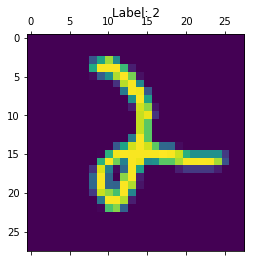

In [67]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28,28))
ax.set_title("Label: %i"% training_targets.loc[rand_example])
ax.grid(False)

In [68]:
def construct_feature_columns():
    return set([tf.feature_column.numeric_column('pixels',shape=784)])

In [25]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle = True):
    """Custon input function for sending MNIST data to the estimator for training
    
    Args:
    features: training features
    labels: training labels
    batch_size: training batch size
    
    Returns:
    A function that returns batches of training features and labels during training
    
    """
    
    def _input_fn(num_epochs=None, shuffle=True):
        idx = np.random.permutation(features.index)
        raw_features = {"pixels":features.reindex(idx)}
        raw_targets = np.array(labels[idx])
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        
        if shuffle:
            ds = ds.shuffle(10000)
            
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    
    return _input_fn

In [26]:
def create_predict_input_fn(features, labels, batch_size, num_epochs=None, shuffle = True):
    """Custon input function for sending MNIST data to the estimator for predictions
    
    Args:
    features: features to base predictions on
    labels: labels of the prediction examples
    batch_size: batch size
    
    Returns:
    A function that returns batches of training features and labels during training
    
    """
    
    def _input_fn():
        raw_features = {"pixels":features.values}
        raw_targets = np.array(labels)
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size)
          
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    
    return _input_fn

In [31]:
def train_linear_classification_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """ Trains a linear classification model for the MNIST digits dataset
    
    Also outputs training progess and confusion matrix
    
    Args:
        learning_rate: A `float`, the learning rate to use.
        steps: A non-zero `int`, the total number of training steps. A training step
              consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        training_examples: A `DataFrame` containing the training features.
        training_targets: A `DataFrame` containing the training labels.
        validation_examples: A `DataFrame` containing the validation features.
        validation_targets: A `DataFrame` containing the validation labels.
    
    Returns:
        trained 'LinearClassifier' object
    """
    
    periods = 10
    
    steps_per_period = steps / periods
    
    predict_training_input_fn = create_predict_input_fn(
        training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, training_targets, batch_size)
    
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.LinearClassifier(
        feature_columns=construct_feature_columns(),
        n_classes=10,
        optimizer=my_optimizer,
        config=tf.estimator.RunConfig(keep_checkpoint_max=1)
    )
    
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0,periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)
        
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        
        accuracy = metrics.accuracy_score(validation_targets, validation_pred_class_id)
        
        print("  period %02d : %0.2f = accuracy of %0.2f" % (period, validation_log_loss, accuracy))
    print("Model training finished.")
    
    # Remove event files to save disk space
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir,'events.out.tfevents*')))
    
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)
    
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs Periods")
    plt.plot(training_errors,label="training")
    plt.plot(validation_errors,label="validation")
    plt.legend()
    plt.show()
    
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    cm_normalized = cm.astype("float") / cm.sum(axis = 1)[:,np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    return classifier
    

Training model...
LogLoss error (on validation data):
  period 00 : 18.85 = accuracy of 0.45
  period 01 : 9.78 = accuracy of 0.72
  period 02 : 8.52 = accuracy of 0.75
  period 03 : 7.16 = accuracy of 0.79
  period 04 : 5.72 = accuracy of 0.83
  period 05 : 5.89 = accuracy of 0.83
  period 06 : 6.07 = accuracy of 0.82
  period 07 : 5.57 = accuracy of 0.84
  period 08 : 5.42 = accuracy of 0.84
  period 09 : 5.25 = accuracy of 0.85
Model training finished.
Final accuracy (on validation data): 0.85


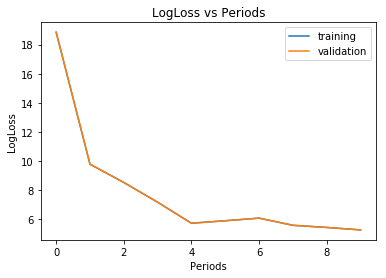

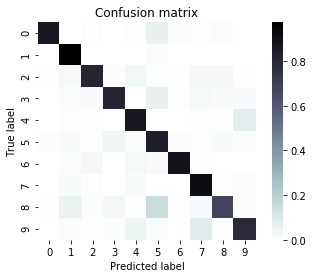

In [32]:
classifier = train_linear_classification_model(
             learning_rate=0.06,
             steps=100,
             batch_size=10,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

In [39]:
def train_nn_classification_model(
    learning_rate,
    steps,
    hidden_units,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """ Trains a linear classification model for the MNIST digits dataset
    
    Also outputs training progess and confusion matrix
    
    Args:
        learning_rate: A `float`, the learning rate to use.
        steps: A non-zero `int`, the total number of training steps. A training step
              consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        training_examples: A `DataFrame` containing the training features.
        training_targets: A `DataFrame` containing the training labels.
        validation_examples: A `DataFrame` containing the validation features.
        validation_targets: A `DataFrame` containing the validation labels.
    
    Returns:
        trained 'LinearClassifier' object
    """
    
    periods = 10
    
    steps_per_period = steps / periods
    
    predict_training_input_fn = create_predict_input_fn(
        training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, training_targets, batch_size)
    
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=construct_feature_columns(),
        n_classes=10,
        hidden_units=hidden_units,
        optimizer=my_optimizer,
        config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
    )
    
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0,periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)
        
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        
        accuracy = metrics.accuracy_score(validation_targets, validation_pred_class_id)
        
        print("  period %02d : %0.2f = accuracy of %0.2f" % (period, validation_log_loss, accuracy))
    print("Model training finished.")
    
    # Remove event files to save disk space
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir,'events.out.tfevents*')))
    
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)
    
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs Periods")
    plt.plot(training_errors,label="training")
    plt.plot(validation_errors,label="validation")
    plt.legend()
    plt.show()
    
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    cm_normalized = cm.astype("float") / cm.sum(axis = 1)[:,np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    return classifier
    

Training model...
LogLoss error (on validation data):
  period 00 : 10.23 = accuracy of 0.70
  period 01 : 4.73 = accuracy of 0.86
  period 02 : 3.99 = accuracy of 0.88
  period 03 : 4.43 = accuracy of 0.87
  period 04 : 2.83 = accuracy of 0.92
  period 05 : 3.34 = accuracy of 0.90
  period 06 : 2.84 = accuracy of 0.92
  period 07 : 2.25 = accuracy of 0.93
  period 08 : 1.98 = accuracy of 0.94
  period 09 : 1.78 = accuracy of 0.95
Model training finished.
Final accuracy (on validation data): 0.95


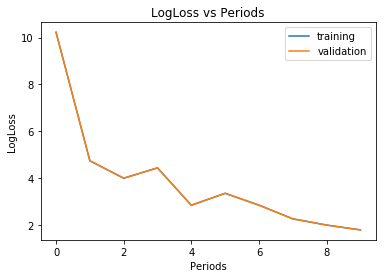

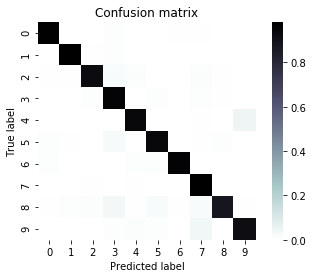

In [44]:
nn_classifier = train_nn_classification_model(
             learning_rate=0.07,
             steps=500,
             hidden_units=[100,100],
             batch_size=20,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

In [45]:
mnist_test_dataframe = pd.read_csv(
    "https://download.mlcc.google.com/mledu-datasets/mnist_test.csv",
    sep=",",
    header=None)

test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)
test_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size=100)

test_predictions = nn_classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
# test_probabilities = np.array([item['probabilities'][1] for item in test_predictions])

accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)


Accuracy on test data: 0.93


['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 100)


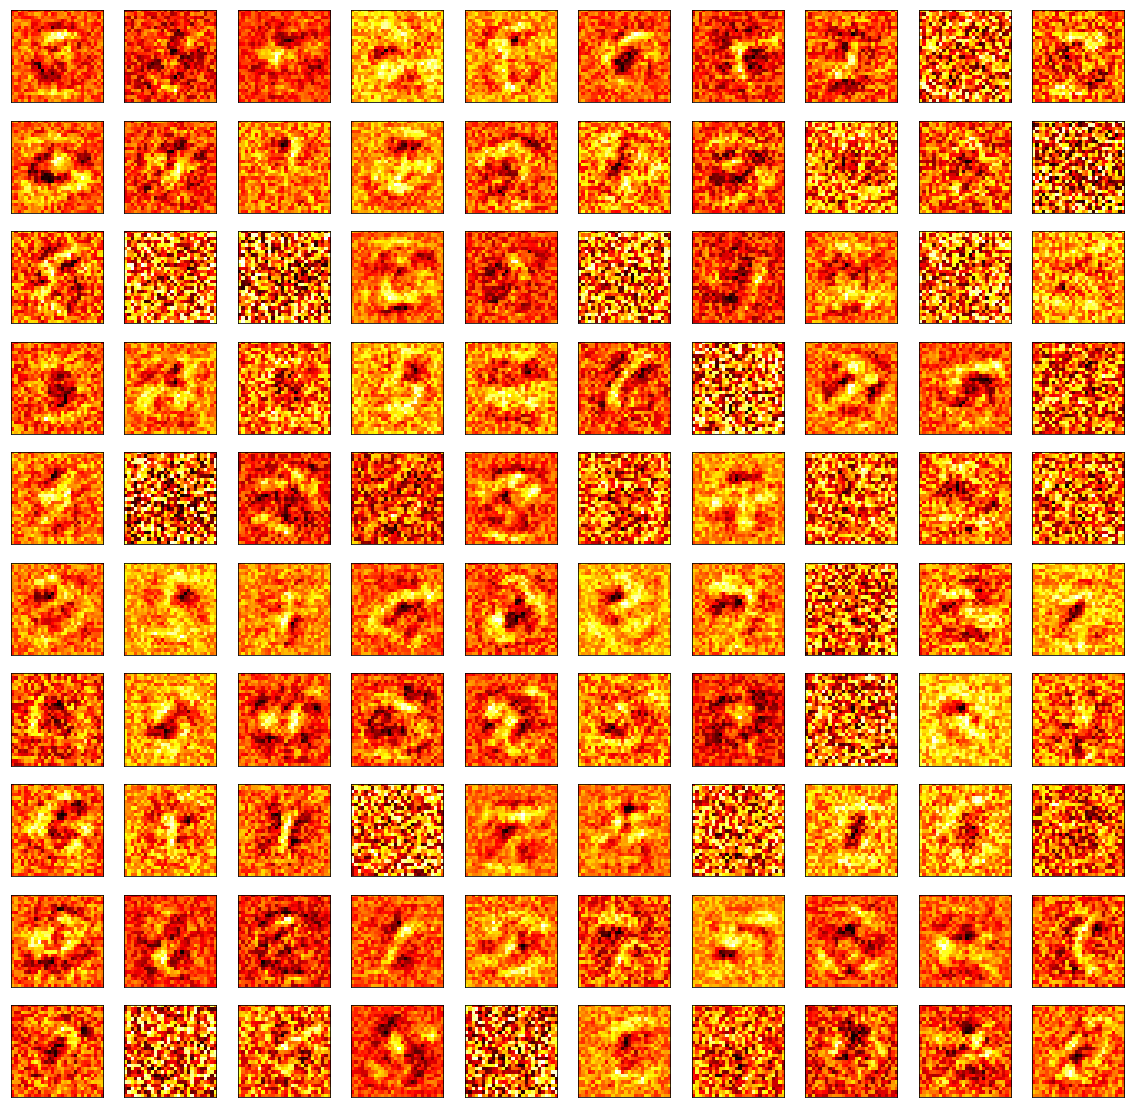

In [56]:
print(nn_classifier.get_variable_names())

weights0 = nn_classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize = (20,2*num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    ax.matshow(coef.reshape(28,28), cmap=plt.cm.hot)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()
    
    

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights1 shape: (784, 100)
Second Hidden Layer Weights: 


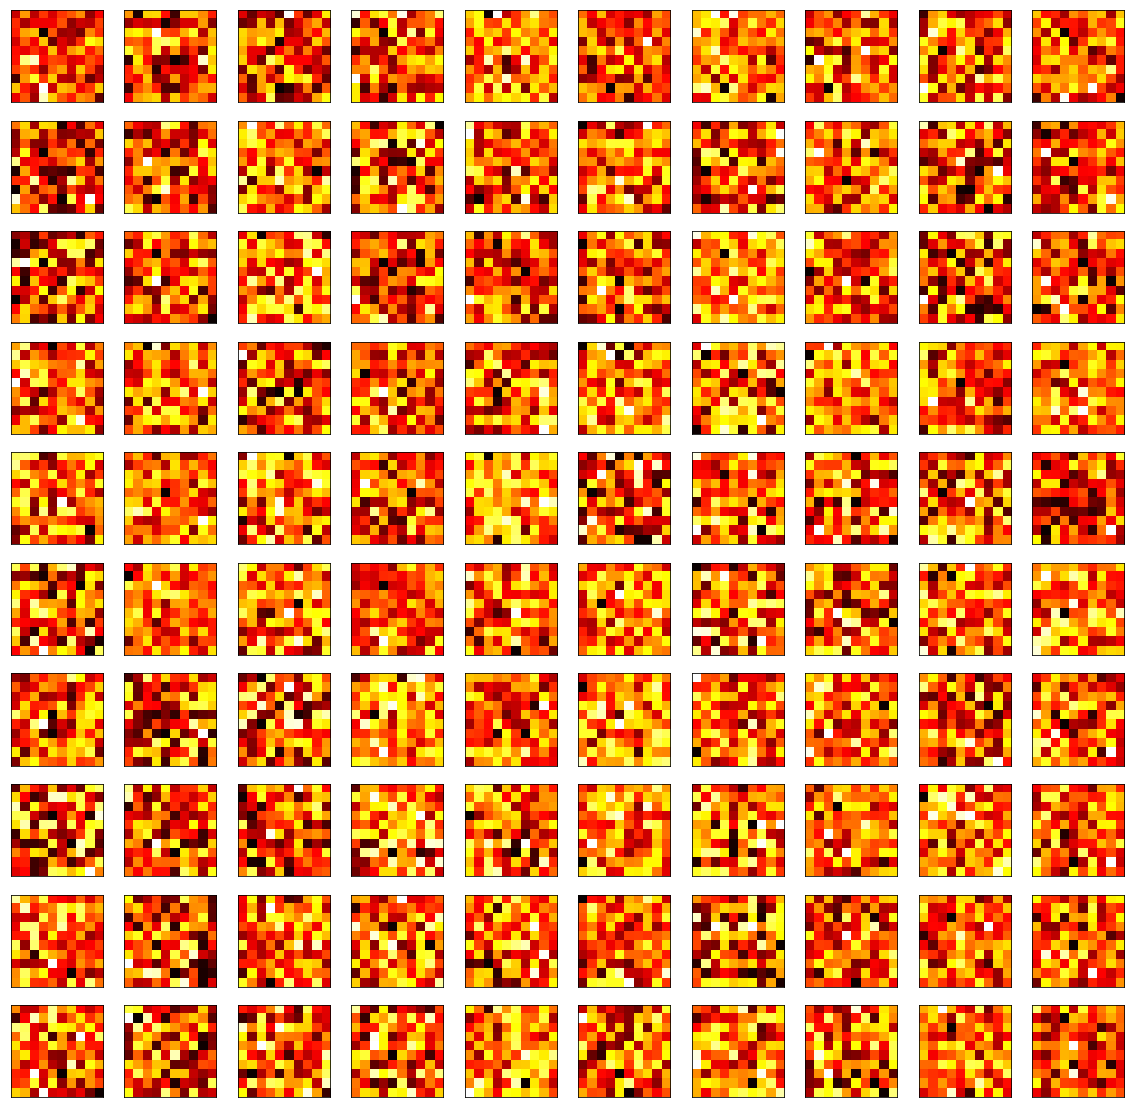

In [61]:
print(nn_classifier.get_variable_names())

weights1 = nn_classifier.get_variable_value("dnn/hiddenlayer_1/kernel")

print("weights1 shape:", weights0.shape)

print("Second Hidden Layer Weights: ")

num_nodes = weights1.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize = (20,2*num_rows))
for coef, ax in zip(weights1.T, axes.ravel()):
    ax.matshow(coef.reshape(10,10), cmap = plt.cm.hot)
    ax.set_xticks(())
    ax.set_yticks(())
    
plt.show()

Training model...
LogLoss error (on validation data):
  period 00 : 5.72 = accuracy of 0.83
  period 01 : 4.01 = accuracy of 0.88
  period 02 : 2.76 = accuracy of 0.92
  period 03 : 2.49 = accuracy of 0.93
  period 04 : 2.66 = accuracy of 0.92
  period 05 : 2.28 = accuracy of 0.93
  period 06 : 1.55 = accuracy of 0.96
  period 07 : 1.59 = accuracy of 0.95
  period 08 : 1.50 = accuracy of 0.96
  period 09 : 1.43 = accuracy of 0.96
Model training finished.
Final accuracy (on validation data): 0.96


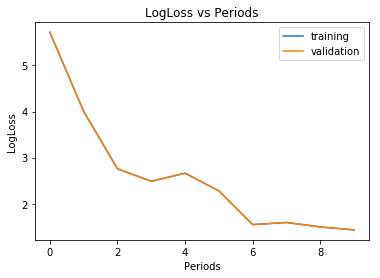

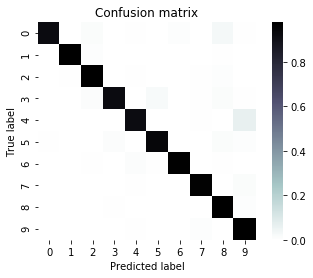

In [60]:
nn_classifier2 = train_nn_classification_model(
             learning_rate=0.07,
             steps=1000,
             hidden_units=[100,100,100],
             batch_size=20,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

Training model...
LogLoss error (on validation data):
  period 00 : 4.84 = accuracy of 0.86
  period 01 : 2.76 = accuracy of 0.92
  period 02 : 2.31 = accuracy of 0.93
  period 03 : 1.91 = accuracy of 0.94
  period 04 : 1.90 = accuracy of 0.94
  period 05 : 1.67 = accuracy of 0.95
  period 06 : 1.20 = accuracy of 0.97
  period 07 : 1.17 = accuracy of 0.97
  period 08 : 0.97 = accuracy of 0.97
  period 09 : 0.94 = accuracy of 0.97
Model training finished.
Final accuracy (on validation data): 0.97


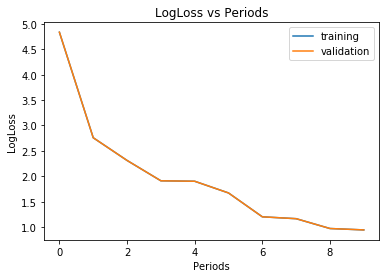

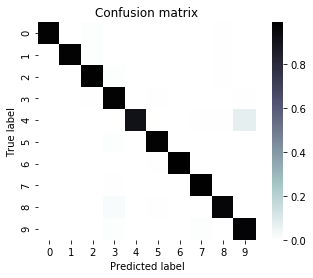

In [69]:
nn_classifier3 = train_nn_classification_model(
             learning_rate=0.07,
             steps=1000,
             hidden_units=[100],
             batch_size=20,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 100)


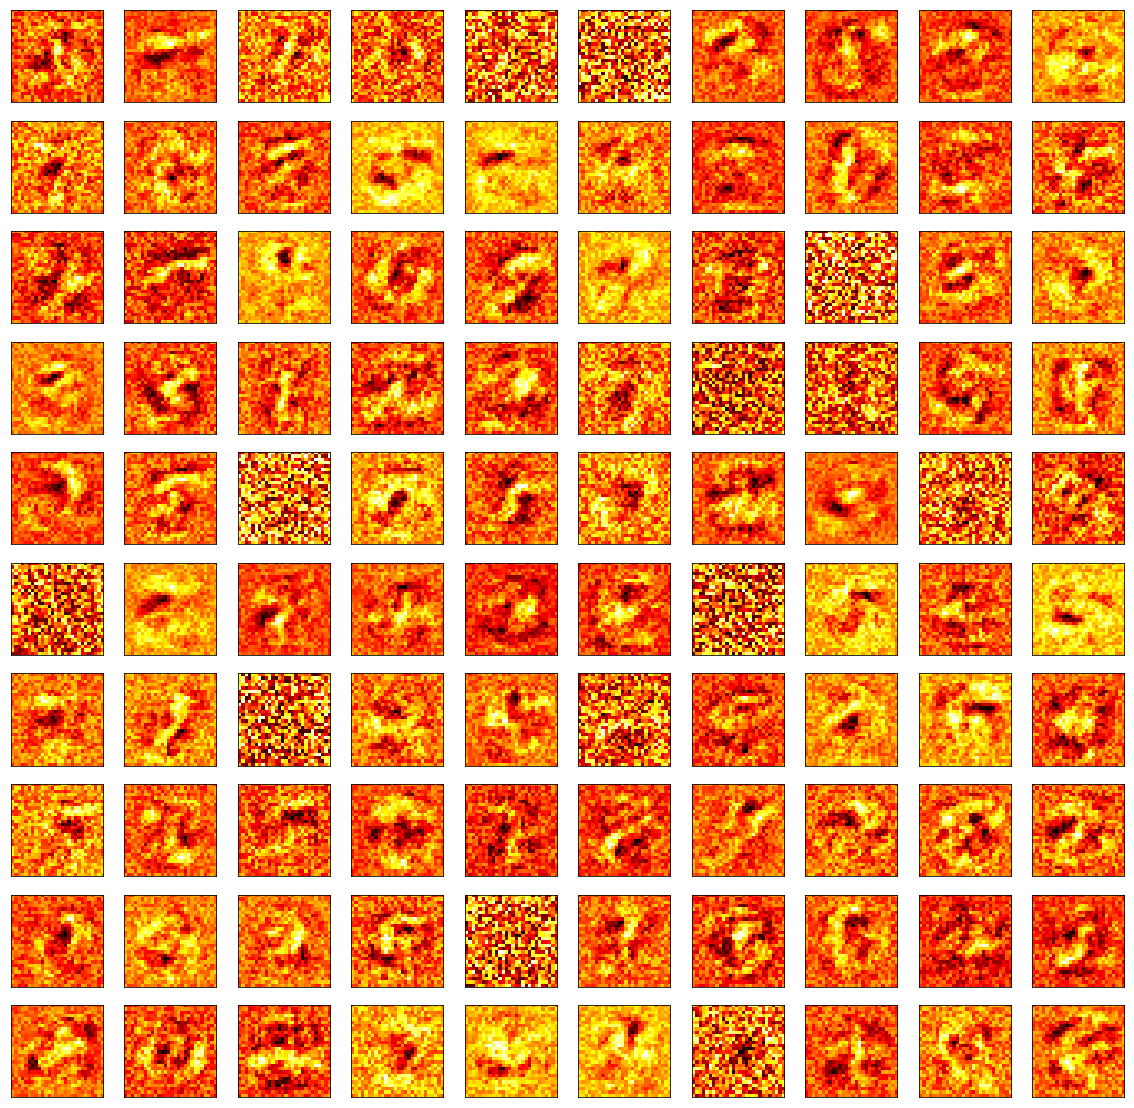

In [70]:
print(nn_classifier3.get_variable_names())

weights0 = nn_classifier3.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize = (20,2*num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    ax.matshow(coef.reshape(28,28), cmap=plt.cm.hot)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [71]:
predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size=100)

test_predictions = nn_classifier3.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
# test_probabilities = np.array([item['probabilities'][1] for item in test_predictions])

accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

Accuracy on test data: 0.94
